**Notebook**

**1. Card Detection** 

***1.1 Paths, Model, CUDA Installation*** 

In [ ]:
#Install Packages
!pip install opencv-python
!pip install --upgrade pyqt5 lxml

In [2]:
#Import dependecis
import cv2
import uuid
import os
import time
import wget

In [3]:
#Installing Tensorflow
CUSTOM_MODEL_NAME = 'Playing_Card_Model_V5'
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME ='generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'


In [4]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow', 'scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow', 'models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace', 'annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace', 'images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace', 'models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace', 'pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace', 'models', CUSTOM_MODEL_NAME),
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace', 'models', CUSTOM_MODEL_NAME, 'export'),
    'TFJS_PATH': os.path.join('Tensorflow', 'workspace', 'models', CUSTOM_MODEL_NAME, 'tfjsexport'),
    'TFLITE_PATH': os.path.join('Tensorflow', 'workspace', 'models', CUSTOM_MODEL_NAME, 'tfliteexport'),
    'PROTOC_PATH': os.path.join('Tensorflow', 'protoc')
}


In [5]:
files = {
    'PIPELINE_CONFIG': os.path.join('Tensorflow', 'workspace', 'models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME),
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}


In [6]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir - p {path}
        if os.name == 'nt':
            !mkdir {path}


In [7]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

In [ ]:
# Install Tensorflow Object Detection 
if os.name=='posix':  
    !apt-get install protobuf-compiler
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install . 
    
if os.name=='nt':
    url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
    wget.download(url)
    !move protoc-3.15.6-win64.zip {paths['PROTOC_PATH']}
    !cd {paths['PROTOC_PATH']} && tar -xf protoc-3.15.6-win64.zip
    os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(paths['PROTOC_PATH'], 'bin'))   
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf2\\setup.py setup.py && python setup.py build && python setup.py install
    !cd Tensorflow/models/research/slim && pip install -e . 

In [ ]:
VERIFICATION_SCRIPT = os.path.join(
    paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
# Verify Installation
!python {VERIFICATION_SCRIPT}


In [10]:
import object_detection

In [ ]:
if os.name == 'posix':
    !wget {PRETRAINED_MODEL_URL}
    !mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}
if os.name == 'nt':
    wget.download(PRETRAINED_MODEL_URL)
    !move {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}


***1.2 Creating the Labels MAP for the Cards***

In [12]:
labels = [{'name': '2C', 'id': 1}, {'name': '2S', 'id': 2}, {'name': '2H', 'id': 3}, 
          {'name': '2D', 'id': 4}, {'name': '3C', 'id': 5}, {'name': '3D', 'id': 6}, 
          {'name': '3H', 'id': 7}, {'name': '3S', 'id': 8}, {'name': '4C', 'id': 9},  
          {'name': '4D', 'id': 10}, {'name': '4H', 'id': 11}, {'name': '4S', 'id': 12}, 
          {'name': '5C', 'id': 13}, {'name': '5D', 'id': 14}, {'name': '5H', 'id': 15}, 
          {'name': '5S', 'id': 16}, {'name': '6C', 'id': 17}, 
          {'name': '6D', 'id': 18}, {'name': '6H', 'id': 19}, {'name': '6S', 'id': 20},
          {'name': '7C', 'id': 21}, {'name': '7D', 'id': 22}, {'name': '7H', 'id': 23}, 
          {'name': '7S', 'id': 24}, {'name': '8C', 'id': 25}, {'name': '8D', 'id': 26}, 
          {'name': '8H', 'id': 27}, {'name': '8S', 'id': 28}, {'name': '9C', 'id': 29},{'name': '9D', 'id': 30}, {'name': '9H', 'id': 31}, 
          {'name': '9S', 'id': 32}, {'name': '10C', 'id': 33}, {'name': '10D', 'id': 34},  
          {'name': '10H', 'id': 35}, {'name': '10S', 'id': 36}, {'name': 'AC', 'id': 37}, 
          {'name': 'AD', 'id': 38}, {'name': 'AH', 'id': 39}, {'name': 'AS', 'id': 40}, 
          {'name': 'CardBack', 'id': 41}, {'name': 'JC', 'id': 42}, {'name': 'JD', 'id': 43}, 
          {'name': 'JH', 'id': 44}, {'name': 'JS', 'id': 45}, {'name': 'KC', 'id': 46},  
          {'name': 'KD', 'id': 47}, {'name': 'KH', 'id': 48}, {'name': 'KS', 'id': 49}, 
          {'name': 'QC', 'id': 50}, {'name': 'QD', 'id': 51}, {'name': 'QH', 'id': 52}, 
          {'name': 'QS', 'id': 53}]
         

with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n ')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')


In [13]:
#TFRecord are a binary format for storing data. Using a TFRecord helps speed up training for your custom obnject detection model
if not os.path.exists(files['TF_RECORD_SCRIPT']):
    !git clone https://github.com/nicknochnack/GenerateTFRecord {paths['SCRIPTS_PATH']}

In [ ]:
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'train')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'train.record')} 
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'test')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'test.record')}

In [ ]:
if os.name == 'posix':
    !cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}
if os.name == 'nt':
    !copy {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}


In [ ]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

config

In [17]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:
    proto_str = f.read()
    text_format.Merge(proto_str, pipeline_config)

In [18]:
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 42
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(
    paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path = files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [
    os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [
    os.path.join(paths['ANNOTATION_PATH'], 'test.record')]

In [19]:
config_text = text_format.MessageToString(pipeline_config)
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:
    f.write(config_text)


In [ ]:
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')

command = 'python {} --model_dir={} --pipeline_config_path={} --num_train_steps=2000'.format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'], files['PIPELINE_CONFIG'])

print(command)

In [21]:
command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'])

In [ ]:
print(command)


In [ ]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [24]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(
    model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-9')).expect_partial()


@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections


In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
category_index = label_map_util.create_category_index_from_labelmap(
    files['LABELMAP'])


In [ ]:
IMAGE_PATH = os.path.join(
    paths['IMAGE_PATH'], 'test', '2H.7bf30d25-ef40-11ed-b542-001583fd4f24.jpg')


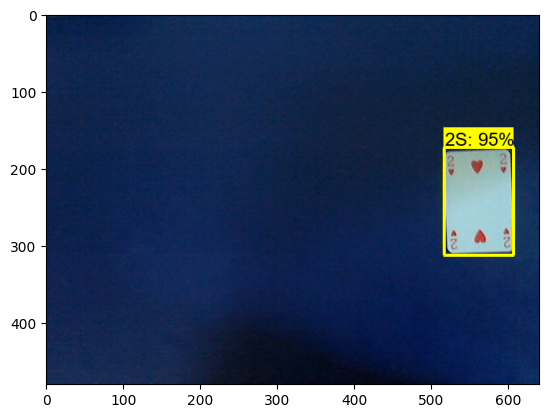

In [83]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(
    np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
    image_np_with_detections,
    detections['detection_boxes'],
    detections['detection_classes']+label_id_offset,
    detections['detection_scores'],
    category_index,
    use_normalized_coordinates=True,
    max_boxes_to_draw=5,
    min_score_thresh=.8,
    agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()


In [36]:
!pip uninstall opencv-python-headless -y

In [ ]:
import six

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Determine the middle line position
middle_line = height // 2

# Initialize counters for upper and lower parts
upper_points = 0
lower_points = 0

card_points = {
    'AC': 11,
    'AS': 11,
    'AD': 11,
    'AH': 11,
    'KS': 10,
    'JS': 10,
    'QS': 10,
    '10S': 10,
    '9S': 9,
    '8S': 8,
    '7S': 7,
    '6S': 6,
    '5S': 5,
    '4S': 4,
    '3S': 3,
    '2S': 2,
    '1S': 1,
    'KC': 10,
    'JC': 10,
    'QC': 10,
    '10C': 10,
    '9C': 9,
    '8C': 8,
    '7C': 7,
    '6C': 6,
    '5C': 5,
    '4C': 4,
    '3C': 3,
    '2C': 2,
    '1C': 1,
    'KD': 10,
    'JD': 10,
    'QD': 10,
    '10D': 10,
    '9D': 9,
    '8D': 8,
    '7D': 7,
    '6D': 6,
    '5D': 5,
    '4D': 4,
    '3D': 3,
    '2D': 2,
    '1D': 1,
    'KH': 10,
    'JH': 10,
    'QH': 10,
    '10H': 10,
    '9H': 9,
    '8H': 8,
    '7H': 7,
    '6H': 6,
    '5H': 5,
    '4H': 4,
    '3H': 3,
    '2H': 2,
    '1H': 1
}

while cap.isOpened():
    ret, frame = cap.read()
    image_np = np.array(frame)

    input_tensor = tf.convert_to_tensor(
        np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)

    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections
    detections['detection_classes'] = detections['detection_classes'].astype(
        np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    # Reset points counters if no cards were detected
    upper_points = 0
    lower_points = 0

    # Keep track of Ace cards
    ace_detected_upper = False
    ace_detected_lower = False

    # Keep track of BUST condition
    upper_bust = False
    lower_bust = False

    # Iterate over detections
    for i in range(num_detections):
        label = category_index[detections['detection_classes']
                               [i] + label_id_offset]['name']
        score = detections['detection_scores'][i]
        box = detections['detection_boxes'][i]

        # Check if the detection confidence is above 80%
        if score > 0.7:
            # Calculate the card value based on the rank and add it to the respective points counter
            rank = label[:-1]
            suit = label[-1]
            value = card_points.get(rank + suit, 0)

            # Determine if the card is in the upper or lower part based on its bounding box
            y_min = int(box[0] * height)
            y_max = int(box[2] * height)
            if y_max < middle_line:
                upper_points += value
            else:
                lower_points += value

            # Check if an Ace card is detected
            if rank == 'A':
                if y_max < middle_line:
                    ace_detected_upper = True
                else:
                    ace_detected_upper = False

            if rank == 'A':
                if y_max > middle_line:
                    ace_detected_lower = True
                else:
                    ace_detected_lower = False
                   

            # Display the card rank and value on the image
            cv2.putText(image_np_with_detections, f"{rank} ({value})", (int(box[1] * width), int(box[0] * height)),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)


    # Adjust value of Ace card if necessary
    if ace_detected_upper and upper_points > 21:
        upper_points -= 10

    if ace_detected_lower and lower_points > 21:
        lower_points -= 10

    # Check for BUST condition
    if upper_points > 21:
        upper_bust = True
    if lower_points > 21:
        lower_bust = True

    # Draw the dividing line
    cv2.line(image_np_with_detections, (0, middle_line),
             (width, middle_line), (0, 0, 255), 2)

    # Draw points counters and BUST indicators
    cv2.rectangle(image_np_with_detections, (width - 200, 10),
                  (width - 10, 80), (255, 0, 0), -1)
    cv2.rectangle(image_np_with_detections, (width - 200, height - 80),
                  (width - 10, height - 10), (0, 0, 255), -1)

    # Display upper points
    cv2.putText(image_np_with_detections, f"{upper_points}", (width - 180, 60),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Display lower points
    cv2.putText(image_np_with_detections, f"{lower_points}", (width - 180, height - 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    # Check for Blackjack condition
    if upper_points == 21 or lower_points == 21:
        cv2.putText(image_np_with_detections, "Blackjack!", (100, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 255), 2)
        
    if upper_bust and lower_bust:
        cv2.putText(image_np_with_detections, "BUST - Both Lose", (10, height - 20),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 3)
    elif upper_bust:
        cv2.putText(image_np_with_detections, "BUST - You Win!", (10, height - 20),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 3)
    elif lower_bust:
        cv2.putText(image_np_with_detections, "BUST - Dealer Wins!", (10, height - 20),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 3)
    elif upper_points >= 16:
        if upper_points > lower_points:
            cv2.putText(image_np_with_detections, "Dealer Wins!", (width - 120, 60),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
            cv2.putText(image_np_with_detections, "You Lose!", (width - 120, height - 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
        elif lower_points > upper_points:
            cv2.putText(image_np_with_detections, "You Win!", (width - 120, height - 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
            cv2.putText(image_np_with_detections, "Dealer Loses!", (width - 120, 60),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
        else:
            cv2.putText(image_np_with_detections, "PUSH - Tie", (10, height - 20),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 3)

    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections['detection_boxes'],
        detections['detection_classes'] + label_id_offset,
        detections['detection_scores'],
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=5,
        min_score_thresh=0.7,
        agnostic_mode=False
    )

    cv2.imshow('object detection', cv2.resize(
        image_np_with_detections, (800, 600)))

    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break
